# Heart Disease Prediction

## Import All Necessary Libraries

In [59]:
import matplotlib.pyplot as plt
import pandas as pd
import pyAgrum as gum
import pyAgrum.lib.notebook as gnb
from imblearn.under_sampling import RandomUnderSampler
import seaborn as sns

## Load in and treat data

In [60]:
# Read in data and treat to reduce categorical size
data = pd.read_csv("heart_2020_original.csv")

# Functions to reduce category sizes
def disDiabetes(data):
    diab = (data["Diabetic"])
    if diab[0] == "Y":
        return "Yes"
    else:
        return "No"

def disAge(data):
    age = data["AgeCategory"]
    if age == "18-24" or age == "25-29" or age == "30-34" or age == "35-39":
        return "18-39"
    elif age == "40-44" or age == "45-49" or age == "50-54" or age == "55-59":
        return "40-59"
    else:
        return "60 or older"

def treat(data):
    # Remove unused columns
    data.drop(["SkinCancer"], axis=1, inplace=True)
    data.drop(["Race"], axis=1, inplace=True)

    # Adjust value representation
    data["Diabetic"] = data.apply(disDiabetes, axis=1)
    data["AgeCategory"] = data.apply(disAge, axis=1)

treat(data)

## Undersample data and split into test and train data sets

In [61]:
# Split data for training and testing
train_data = data.sample(frac=0.75, random_state=21)
test_data = data.drop(train_data.index)

# Get heart disease distribution
data["HeartDisease"].value_counts(normalize=True)

# Only 8.5% target heart disease so use undersampling for a better model
rus = RandomUnderSampler(random_state=21)
X_train_data_us, Y_train_data_us = rus.fit_resample(train_data.drop(["HeartDisease"], axis=1), train_data["HeartDisease"])

# Merge undersampled data for ease of reading with CSV
train_data_us = pd.concat([Y_train_data_us, X_train_data_us], axis=1)

# Output CSVs for loading in BN
train_data_us.to_csv("heart_train.csv", index=False)
#train_data.to_csv("heart_train.csv", index=False)
test_data.to_csv("heart_test.csv", index=False)

## EDA
### Get countplots for categorical variables and empirical distributions for continous variables

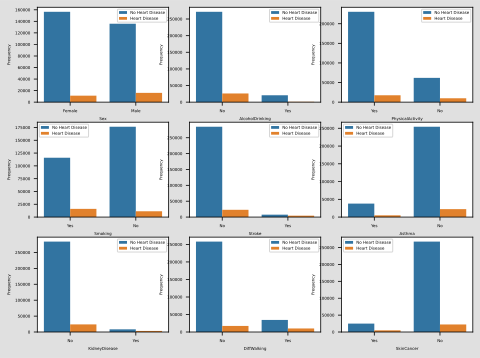

In [62]:
unTransformedData = pd.read_csv("heart_2020_original.csv")
plt.rcParams.update({'font.size': 4})
catagoricalVariables = ['Sex', 'Smoking', 'KidneyDisease', 'AlcoholDrinking', 'Stroke', 'DiffWalking', 'PhysicalActivity', 'Asthma', 'SkinCancer']
fig, ax = plt.subplots(3, 3)
fig.tight_layout(h_pad=2)
x = 0
y = 0
for i in catagoricalVariables:
    sns.countplot(x= unTransformedData[i], hue = 'HeartDisease', data = data, ax=ax[x, y])
    ax[x, y].set_xlabel(i)
    ax[x, y].legend(['No Heart Disease', 'Heart Disease'])
    ax[x, y].set_ylabel('Frequency')
    #ax[x, y].set_title(i)
    x += 1
    if (x == 3):
        y += 1
        x = 0
fig.savefig("BinaryVar")

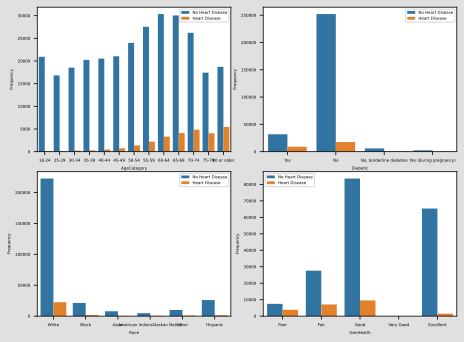

In [63]:
plt.rcParams.update({'font.size': 4})
catagoricalVariables = ['AgeCategory', 'Race', 'Diabetic', 'GenHealth']
fig, ax = plt.subplots(2, 2)
fig.tight_layout(h_pad=2, w_pad=4, pad=3)
x = 0
y = 0
for i in catagoricalVariables:
    if (i == 'AgeCategory'):
        order = ["18-24", "25-29", "30-34", "35-39", "40-44", "45-49", "50-54", "55-59", "60-64", "65-69", "70-74", "75-79", "80 or older"]
        sns.countplot(x= unTransformedData[i], hue = 'HeartDisease', data = data, ax=ax[x, y], order = order)
    elif (i == "GenHealth"):
      order = ["Poor", "Fair", "Good", "Very Good", "Excellent"]
      sns.countplot(x= unTransformedData[i], hue = 'HeartDisease', data = data, ax=ax[x, y], order = order)
    else:
        sns.countplot(x= unTransformedData[i], hue = 'HeartDisease', data = data, ax=ax[x, y])
    ax[x, y].set_xlabel(i)
    ax[x, y].legend(['No Heart Disease', 'Heart Disease'])
    ax[x, y].set_ylabel('Frequency')
    #ax[x, y].set_title(i)
    x += 1
    if (x == 2):
        y += 1
        x = 0
plt.show()

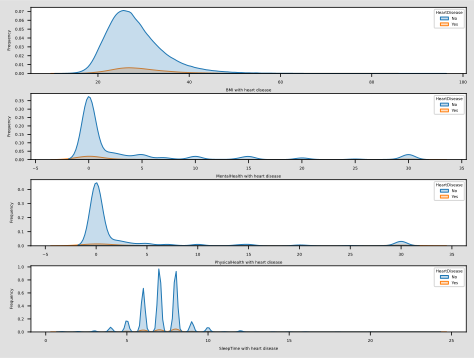

In [64]:
plt.rcParams.update({'font.size': 4})
HeartDisease = unTransformedData.loc[data['HeartDisease'] == "Yes"]
NoHeartDisease = unTransformedData.loc[data["HeartDisease"] == "No"]
continousVariables = ['BMI', 'MentalHealth', 'PhysicalHealth', 'SleepTime']
fig, ax = plt.subplots(4, 1)
fig.tight_layout(h_pad=2)
x = 0
y = 0

for i in continousVariables:
    sns.kdeplot(ax=ax[x], data=data, x=i, hue='HeartDisease', fill=True)
    ax[x].set_xlabel(i + " with heart disease")
    ax[x].set_ylabel('Frequency')
    x +=1
plt.show()

### Correlation Plot on Undersampled data

interval columns not set, guessing: ['BMI', 'PhysicalHealth', 'MentalHealth', 'SleepTime']


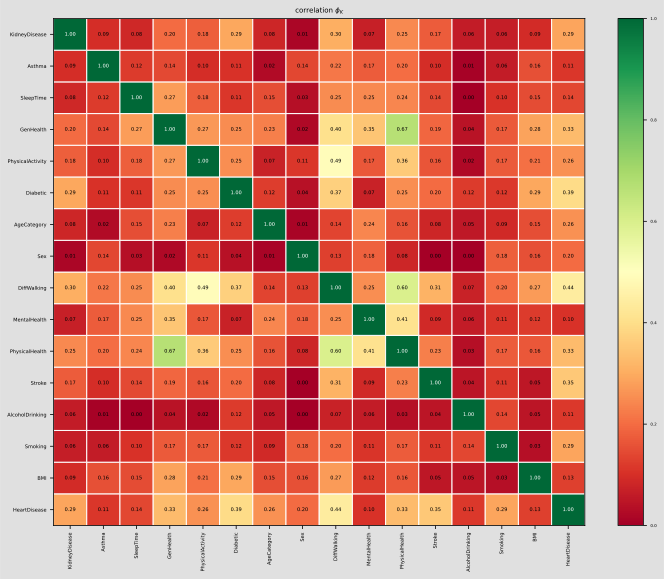

In [65]:
import phik
from phik.report import plot_correlation_matrix
from phik import report

phik_overview = train_data_us.phik_matrix()
phik_overview.round(1)
plot_correlation_matrix(phik_overview.values,
                        x_labels=phik_overview.columns,
                        y_labels=phik_overview.index,
                        vmin=0, vmax=1,
                        title=r"correlation $\phi_K$",
                        fontsize_factor=0.5,
                        figsize=(10, 8))
plt.tight_layout()
plt.savefig("corr.png")

## Bayesian Network
### Define Topology

In [66]:
# Define BN topology
bn = gum.BayesNet("Heart Disease Prediction")

bn.add(gum.LabelizedVariable("HeartDisease", "HeartDisease", ["Yes", "No"]))
bn.add(gum.DiscretizedVariable("BMI", "BMI").addTick(0).addTick(18.5).addTick(25).addTick(30).addTick(100))
bn.add(gum.LabelizedVariable("Smoking", "Smoking", ["Yes", "No"]))
bn.add(gum.LabelizedVariable("AlcoholDrinking",
       "AlcoholDrinking", ["Yes", "No"]))
bn.add(gum.LabelizedVariable("Stroke", "Stroke", ["Yes", "No"]))
bn.add(gum.DiscretizedVariable("PhysicalHealth", "PhysicalHealth").addTick(0).addTick(1).addTick(10).addTick(30))
bn.add(gum.DiscretizedVariable("MentalHealth", "MentalHealth").addTick(
    0).addTick(1).addTick(10).addTick(30))
bn.add(gum.LabelizedVariable("DiffWalking", "DiffWalking", ["Yes", "No"]))
bn.add(gum.LabelizedVariable("Sex", "Sex", ["Male", "Female"]))
bn.add(gum.LabelizedVariable("AgeCategory", "AgeCategory", [
       "18-39", "40-59", "60 or older"]))
bn.add(gum.LabelizedVariable("Diabetic", "Diabetic", ["Yes", "No"]))
bn.add(gum.LabelizedVariable("PhysicalActivity", "PhysicalActivity", ["Yes", "No"]))
bn.add(gum.LabelizedVariable("GenHealth", "GenHealth", ["Very good", "Good", "Excellent", "Fair", "Poor"]))
bn.add(gum.DiscretizedVariable("SleepTime", "SleepTime").addTick(0).addTick(5).addTick(7).addTick(9).addTick(24))
bn.add(gum.LabelizedVariable("Asthma", "Asthma", ["Yes", "No"]))
bn.add(gum.LabelizedVariable("KidneyDisease", "KidneyDisease", ["Yes", "No"]))


15

### View Nodes Added

In [67]:
# View nodes added
print(bn.variable("HeartDisease"))
print(bn.variable("BMI"))
print(bn.variable("Smoking"))
print(bn.variable("AlcoholDrinking"))
print(bn.variable("Stroke"))
print(bn.variable("PhysicalHealth"))
print(bn.variable("MentalHealth"))
print(bn.variable("DiffWalking"))
print(bn.variable("Sex"))
print(bn.variable("AgeCategory"))
print(bn.variable("Diabetic"))
print(bn.variable("PhysicalActivity"))
print(bn.variable("GenHealth"))
print(bn.variable("SleepTime"))
print(bn.variable("Asthma"))
print(bn.variable("KidneyDisease"))

bn

HeartDisease:Labelized({Yes|No})
BMI:Discretized(<[0;18.5[,[18.5;25[,[25;30[,[30;100]>)
Smoking:Labelized({Yes|No})
AlcoholDrinking:Labelized({Yes|No})
Stroke:Labelized({Yes|No})
PhysicalHealth:Discretized(<[0;1[,[1;10[,[10;30]>)
MentalHealth:Discretized(<[0;1[,[1;10[,[10;30]>)
DiffWalking:Labelized({Yes|No})
Sex:Labelized({Male|Female})
AgeCategory:Labelized({18-39|40-59|60 or older})
Diabetic:Labelized({Yes|No})
PhysicalActivity:Labelized({Yes|No})
GenHealth:Labelized({Very good|Good|Excellent|Fair|Poor})
SleepTime:Discretized(<[0;5[,[5;7[,[7;9[,[9;24]>)
Asthma:Labelized({Yes|No})
KidneyDisease:Labelized({Yes|No})


(pyAgrum.BayesNet<double>@0000016EB5C85FE0) BN{nodes: 16, arcs: 0, domainSize: 10^6.34475, dim: 42}

### Define Bayesian Network Structure

In [68]:
# Define the BN structure

links = [("PhysicalActivity","HeartDisease"),
         ("AgeCategory","PhysicalActivity"),
         ("AgeCategory","HeartDisease"),
         ("BMI", "PhysicalActivity"),
         ("BMI", "Diabetic"),
         ("GenHealth", "HeartDisease"),
         ("PhysicalHealth", "GenHealth"),
         ("MentalHealth", "GenHealth"),
         ("SleepTime", "GenHealth"),
         ("BMI", "GenHealth"),
         ("Sex","HeartDisease"),
         ("Smoking","HeartDisease"),
         ("AlcoholDrinking","HeartDisease"),
         ("Diabetic","KidneyDisease"),
         ("KidneyDisease","HeartDisease"),
         ("Diabetic","HeartDisease"),
         ("HeartDisease","DiffWalking"),
         ("HeartDisease", "Stroke"),
         ("Asthma","DiffWalking")]

for link in links:
    bn.addArc(*link)

In [69]:
# Visualise the network with arcs
bn

(pyAgrum.BayesNet<double>@0000016EB5C85FE0) BN{nodes: 16, arcs: 19, domainSize: 10^6.34475, dim: 2713}

### Learn Parameters of the Network

In [70]:
# Learn the parameters of the BN
learner = gum.BNLearner("heart_train.csv", bn)
learner.useSmoothingPrior(2)
bn = learner.learnParameters(bn.dag())
# Save Model

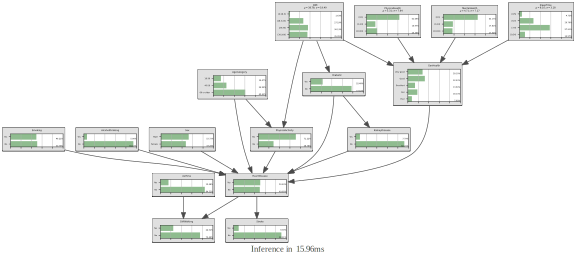


                                                       ||  HeartDisease     |
AgeCat|Physic|Alcoho|Kidney|Smokin|Sex   |GenHea|Diabet||Yes      |No       |
------|------|------|------|------|------|------|------||---------|---------|
18-39 |Yes   |Yes   |Yes   |Yes   |Male  |Very g|Yes   || 0.5000  | 0.5000  |
40-59 |Yes   |Yes   |Yes   |Yes   |Male  |Very g|Yes   || 0.5000  | 0.5000  |
60 or |Yes   |Yes   |Yes   |Yes   |Male  |Very g|Yes   || 0.6000  | 0.4000  |
18-39 |No    |Yes   |Yes   |Yes   |Male  |Very g|Yes   || 0.5000  | 0.5000  |
40-59 |No    |Yes   |Yes   |Yes   |Male  |Very g|Yes   || 0.5000  | 0.5000  |
60 or |No    |Yes   |Yes   |Yes   |Male  |Very g|Yes   || 0.5000  | 0.5000  |
[...948 more line(s) ...]
18-39 |Yes   |No    |No    |No    |Female|Poor  |No    || 0.3333  | 0.6667  |
40-59 |Yes   |No    |No    |No    |Female|Poor  |No    || 0.6429  | 0.3571  |
60 or |Yes   |No    |No    |No    |Female|Poor  |No    || 0.7632  | 0.2368  |
18-39 |No    |No    |No    |No    |Fe

In [71]:
# View learned model
gnb.showInference(bn)
print(bn.cpt("HeartDisease"))

### Validate Model Accuracy

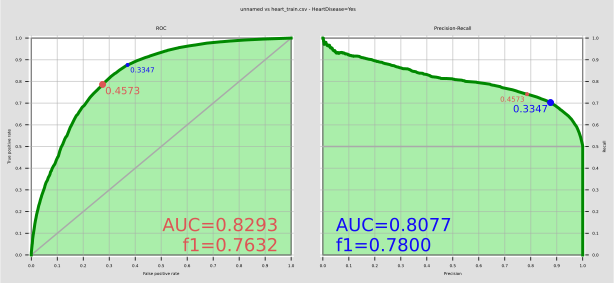

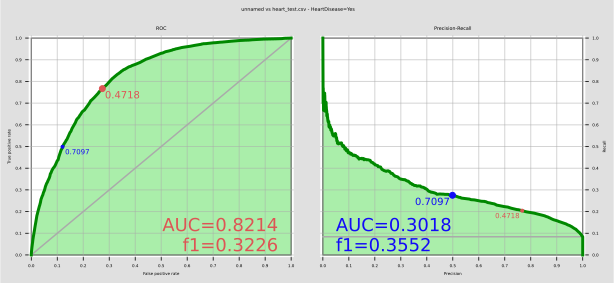

(0.8214230065926437, 0.47179711950000003, 0.3018225257282148, 0.70970417355)

In [72]:
# Validate model accuracy

from pyAgrum.lib.bn2roc import showROC_PR
import pyAgrum.lib.explain as explain

explain.showInformation(bn)

showROC_PR(bn, "heart_train.csv", "HeartDisease", "Yes", False, True)
showROC_PR(bn, "heart_test.csv", "HeartDisease", "Yes", False, True)

### Save Model

In [73]:
gum.saveBN(bn, "bayesianNetwork.bifxml")

# Decision Network
## Set up
Set up Topology and Weights of Decision Network using previous Bayesian Network

In [74]:
# Set up Decision Network
dn = gum.loadID("bayesianNetwork.bifxml")
dn.addUtilityNode(gum.LabelizedVariable("U", "U", 1))
dn.addArc("HeartDisease", "U")
decisionNodes = ["DecreaseSubstanceUse", "GoToDoctor", "IncreasePhysicalActivity"]
for node in decisionNodes:
    dn.addDecisionNode(gum.LabelizedVariable(node, node, ["Yes", "No"]))
    dn.addArc(node, "U")
dn

(pyAgrum.InfluenceDiagram<double>@0000016EB4C4C260) Influence Diagram{
  chance: 16,
  utility: 1,
  decision: 3,
  arcs: 23,
  domainSize: 10^7.24784
}

## Define Utility Function

In [75]:
dn.utility("U")[{"HeartDisease": "Yes", "DecreaseSubstanceUse": "Yes", "GoToDoctor": "Yes", "IncreasePhysicalActivity": "Yes"}] = 100
dn.utility("U")[{"HeartDisease": "Yes", "DecreaseSubstanceUse": "Yes", "GoToDoctor": "Yes", "IncreasePhysicalActivity": "No"}] = 66
dn.utility("U")[{"HeartDisease": "Yes", "DecreaseSubstanceUse": "Yes", "GoToDoctor": "No", "IncreasePhysicalActivity": "Yes"}] = 66
dn.utility("U")[{"HeartDisease": "Yes", "DecreaseSubstanceUse": "Yes", "GoToDoctor": "No", "IncreasePhysicalActivity": "No"}] = 33
dn.utility("U")[{"HeartDisease": "Yes", "DecreaseSubstanceUse": "No", "GoToDoctor": "Yes", "IncreasePhysicalActivity": "Yes"}] = 33
dn.utility("U")[{"HeartDisease": "Yes", "DecreaseSubstanceUse": "No", "GoToDoctor": "Yes", "IncreasePhysicalActivity": "No"}] = 33
dn.utility("U")[{"HeartDisease": "Yes", "DecreaseSubstanceUse": "No", "GoToDoctor": "No", "IncreasePhysicalActivity": "Yes"}] = 33
dn.utility("U")[{"HeartDisease": "Yes", "DecreaseSubstanceUse": "No", "GoToDoctor": "No", "IncreasePhysicalActivity": "No"}] = 0
dn.utility("U")[{"HeartDisease": "No", "DecreaseSubstanceUse": "Yes", "GoToDoctor": "Yes", "IncreasePhysicalActivity": "Yes"}] = 25
dn.utility("U")[{"HeartDisease": "No", "DecreaseSubstanceUse": "Yes", "GoToDoctor": "Yes", "IncreasePhysicalActivity": "No"}] = 33
dn.utility("U")[{"HeartDisease": "No", "DecreaseSubstanceUse": "Yes", "GoToDoctor": "No", "IncreasePhysicalActivity": "Yes"}] = 33
dn.utility("U")[{"HeartDisease": "No", "DecreaseSubstanceUse": "Yes", "GoToDoctor": "No", "IncreasePhysicalActivity": "No"}] = 16
dn.utility("U")[{"HeartDisease": "No", "DecreaseSubstanceUse": "No", "GoToDoctor": "Yes", "IncreasePhysicalActivity": "Yes"}] = 16
dn.utility("U")[{"HeartDisease": "No", "DecreaseSubstanceUse": "No", "GoToDoctor": "Yes", "IncreasePhysicalActivity": "No"}] = 16
dn.utility("U")[{"HeartDisease": "No", "DecreaseSubstanceUse": "No", "GoToDoctor": "No", "IncreasePhysicalActivity": "Yes"}] = 16
dn.utility("U")[{"HeartDisease": "No", "DecreaseSubstanceUse": "No", "GoToDoctor": "No", "IncreasePhysicalActivity": "No"}] = 0

### Save Decision Network

In [76]:
gum.saveBN(dn, "decisionNetwork.bifxml")

### Make Inference

In [77]:
ie=gum.ShaferShenoyLIMIDInference(dn)
try:
    ie.makeInference()
except gum.GumException as e:
    print(e)

ie.addNoForgettingAssumption(["DecreaseSubstanceUse", "GoToDoctor", "IncreasePhysicalActivity"])
gnb.sideBySide(gnb.getInference(dn,engine=ie, evs={'DecreaseSubstanceUse': 'No'}))

[pyAgrum] Fatal error: This LIMID/Influence Diagram is not solvable.


## Model Testing:
### Initial Probability Graph

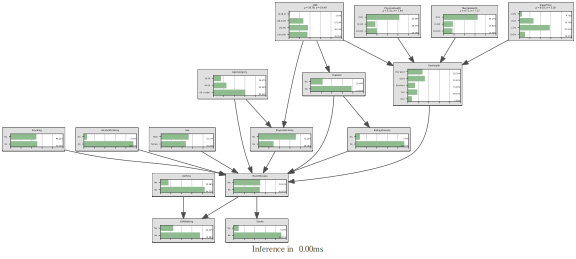

In [78]:
ie = gum.VariableElimination(bn)
gnb.showInference(bn, engine=ie)

In [79]:
# #gnb.show(ie.evidenceImpact("HeartDisease", ["Diabetic", "Sex", "AlcoholDrinking"]))
# gnb.show(ie.evidenceImpact("GenHealth", ["PhysicalHealth", "MentalHealth"]))

### Examples of Diagnostic Reasoning
1) What is the probability that someone is over 60 given that they have Heart Disease

0.7481084476234199


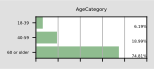

In [80]:
ie.setEvidence({"HeartDisease": "Yes"})
ie.makeInference()
print(ie.posterior("AgeCategory")[2])
gnb.showPosterior(bn, evs={"HeartDisease": "Yes"}, target="AgeCategory")
#print(gnb.showInference(bn, evs={"AgeCategory": "60 or older"}, engine=ie))


2) What is the probability that someone is male given they do not have heart disease and are diabetic

0.5731940278850396


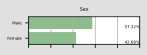

In [81]:
ie.setEvidence({"HeartDisease": "Yes", "Diabetic": "Yes"})
ie.makeInference()
print(ie.posterior("Sex")[0])
gnb.showPosterior(bn, evs={"HeartDisease": "Yes", "Diabetic": "Yes"}, target="Sex")

### Example of Casual Reasoning
1) Probability that someone has heart disease given they are heavy drinkers with kidney disease

0.5248482304330546


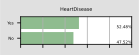

In [82]:
ie.setEvidence({"KidneyDisease": "Yes", "AlcoholDrinking" : "Yes"})
ie.makeInference
print(ie.posterior("HeartDisease")[0])
gnb.showPosterior(bn, {"KidneyDisease": "Yes", "AlcoholDrinking" : "Yes"}, target="HeartDisease")

2) Probability that someone has heart disease given that they are over 60 and have difficulty walking

0.8298204990059594


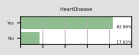

In [83]:
ie.setEvidence({"AgeCategory": "60 or older", "DiffWalking" : "Yes"})
ie.makeInference()
print(ie.posterior("HeartDisease")[0])
gnb.showPosterior(bn, {"AgeCategory": "60 or older", "DiffWalking" : "Yes"}, target="HeartDisease")

3) Probability that someone has heart disease given that they are 18-39 and do not smoke

0.18565398071116335


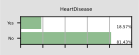

In [84]:
ie.setEvidence({"AgeCategory": "18-39", "Smoking" : "No"})
ie.makeInference()
print(ie.posterior("HeartDisease")[0])
gnb.showPosterior(bn, {"AgeCategory": "18-39", "Smoking" : "No"}, target="HeartDisease")

## Decision Networks
1) Utility of someone to stop drinking and smoking and go to the doctor given that are over 60 and have difficulty walking

In [85]:
ie=gum.ShaferShenoyLIMIDInference(dn)
try:
    ie.makeInference()
except gum.GumException as e:
    print(e)

ie.addNoForgettingAssumption(["DecreaseSubstanceUse", "GoToDoctor", "IncreasePhysicalActivity"])
#gnb.show(dn.utility("U"))
gnb.sideBySide(gnb.getInference(dn,engine=ie, evs={'DecreaseSubstanceUse': 'Yes', "GoToDoctor": "Yes", "AgeCategory": "60 or older", "DiffWalking" : "Yes"}))

[pyAgrum] Fatal error: This LIMID/Influence Diagram is not solvable.


2)Utility of some to increase their physical activity given that they are not diabetic and have excellent general health

In [86]:
gnb.sideBySide(gnb.getInference(dn,engine=ie, evs={'IncreasePhysicalActivity': 'Yes',"GenHealth": "Excellent", "Diabetic" : "No"}))